Welcome to hands-on lab for **Using the Tekton Catalog**. The Tekton community provides a wide selection of tasks and pipelines that you can use in your CI/CD pipelines, so that you do not have to write all of them yourself. Many common tasks can be found at the Tekton Hub. In this lab, you will search for and use one of them.

# Learning Objectives

After completing this lab, you will be able to:
* Use the Tekton CD Catalog to install the git-clone task
* Describe the parameters required to use the git-clone task
* Use the git-clone task in a Tekton pipeline to clone your Git repository

# Set Up the Lab Environment

## Clone the Code Repo

Now, get the code that you need to test. 

To do this, use the `git clone` command to clone the Git repository:
```
git clone https://github.com/ibm-developer-skills-network/wtecc-CICD_PracticeCode.git
```

**Your output should look similar to the image below:**

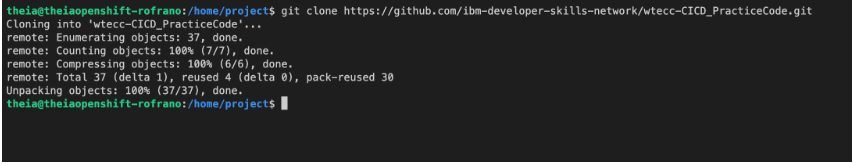

## Change to the Labs Directory

Once you have cloned the repository, change to the labs directory.
```
cd wtecc-CICD_PracticeCode/labs/03_use_tekton_catalog/
```

## Navigate to the Labs Folder

Navigate to the `labs/03_use_tekton_catalog` folder in left explorer panel. 

All of your work will be with the files in this folder.

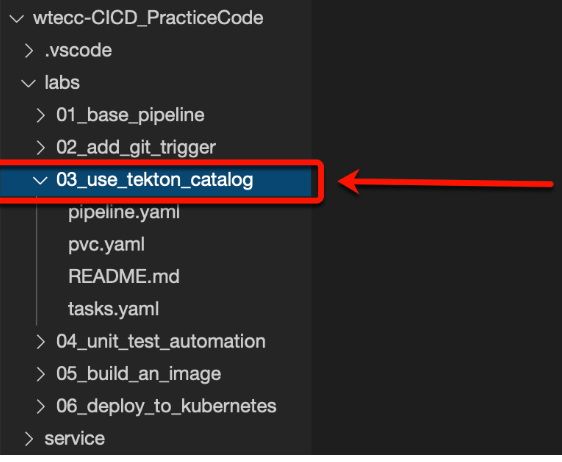

You are now ready to begin with the prerequisites in the next section.

# Prerequisites

This lab requires installation of the tasks introduced in previous labs. 

To be sure, apply the previous tasks to your cluster before proceeding:
```
kubectl apply -f tasks.yaml
```

You should see the output similar to this:
```
$ kubectl apply -f tasks.yaml
task.tekton.dev/echo created
task.tekton.dev/checkout created
```

> **Note:** *If the tasks are already installed, the output will say “configured” instead of “created.”*

You are now ready to start the lab.

# Step 1: Add the git-clone Task

You start by finding a task to replace the `checkout` task you initially created. While it was OK as a learning exercise, it needs a lot more capabilities to be more robust, and it makes sense to use the community-supplied task instead.

**(Optional)** You can browse the **Tekton Hub**, find the `git-clone` command, copy the `URL` to the `yaml` file, and use `kubectl` to apply it manually. But it is much easier to use the **Tekton CLI** once you have found the task that you want.

Use this command to install the `git-clone` task from **Tekton Hub**:
```
tkn hub install task git-clone --version 0.8
```

This installs the `git-clone` task into your cluster under your current active namespace.

> Note: If the above command returns a error due to Tekton Version mismatch, please run the below command to fix this.

```
kubectl apply -f https://raw.githubusercontent.com/tektoncd/catalog/main/task/git-clone/0.9/git-clone.yaml
```

# Step 2: Create a Workspace

Viewing the `git-clone` task requirements, you see that while it supports many more parameters than your original `checkout` task, it only requires two things:
1. The **URL  of a Git repo to clone**, provided with the `url` param
2. A **workspace** called `output`

You start by creating a `PersistentVolumeClaim` (**PVC**) to use as the workspace:
* A **workspace** is a disk volume that can be shared across tasks. 
* The way to bind to volumes in Kubernetes is with a PersistentVolumeClaim.

Since creating PVCs is beyond the scope of this lab, you have been provided with the following `pvc.yaml` file with these contents:

```
apiVersion: v1
kind: PersistentVolumeClaim
metadata:
  name: pipelinerun-pvc
spec:
  storageClassName: skills-network-learner
  resources:
    requests:
      storage:  1Gi
  volumeMode: Filesystem
  accessModes:
    - ReadWriteOnce
```

**Apply the new task definition to the cluster:**

```
kubectl apply -f pvc.yaml
```

**You should see the following output:**

```
persistentvolumeclaim/pipelinerun-pvc created
```

You can now reference this persistent volume by its name `pipelinerun-pvc` when creating workspaces for your Tekton tasks.

# Step 3: Add a Workspace to the Pipeline

* In this step, you will add a **workspace** to the pipeline using the **persistent volume claim** you just created. 
* To do this, you will edit the `pipeline.yaml` file and add a `workspaces:` definition as the first line under the `spec:` but before the `params:` and call it `pipeline-workspace`. 
* Then you will **add the workspace to the pipeline `clone` task** and change the task to reference `git-clone` instead of your `checkout` task.

## Your Task

1. Edit the `pipeline.yaml` file and add a `workspaces:` definition as the first line under the `spec:` but before the `params:` and call it `pipeline-workspace`.

2. Next, add the workspace to the `clone` task after the `name:` and call it `output` because this is the workspace name that the `git-clone` task will be looking for.

3. Change the name of the `taskRef` in the `clone` task to reference the `git-clone` task instead of `checkout`.

4. Finally, change the name of the `repo-url` parameter to `url` because this is the name the `git-clone` tasks expects, but keep the mapping of `$(params.repo-url)`, which is what the pipeline expects. Also, rename the `branch` parameter to `revision`, which is what `git-clone` expects.

## Solution

```
apiVersion: tekton.dev/v1beta1
kind: Pipeline
metadata:
  name: cd-pipeline
spec:
  workspaces:
    - name: pipeline-workspace
  params:
    - name: repo-url
    - name: branch
      default: "master"
  tasks:
    - name: clone
      workspaces:
        - name: output
          workspace: pipeline-workspace
      taskRef:
        name: git-clone
      params:
      - name: url
        value: $(params.repo-url)
      - name: revision
        value: $(params.branch)

    # Note: The remaining tasks are unchanged. Do not delete them.
```

**Apply the pipeline to your cluster:**

```
kubectl apply -f pipeline.yaml
```

**You should see output similar to this:**

```
$ kubectl apply -f pipeline.yaml
pipeline.tekton.dev/cd-pipeline created
```

> **Note:** *If the original pipeline was already created, you will see the word “configured” instead of “created.”*

You are now ready to run your pipeline.

# Step 4: Run the Pipeline

You can now use the **Tekton CLI (`tkn`)** to create a `PipelineRun` to run the pipeline.

Use the following command to run the pipeline, passing in:
* the URL of the repository,
* the branch to clone,
* the workspace name, and
* the persistent volume claim name.

```
tkn pipeline start cd-pipeline \
    -p repo-url="https://github.com/ibm-developer-skills-network/wtecc-CICD_PracticeCode.git" \
    -p branch="main" \
    -w name=pipeline-workspace,claimName=pipelinerun-pvc \
    --showlog
```

**You should see output similar to this:**

```
$ tkn pipeline start cd-pipeline \
>     -p repo-url="https://github.com/ibm-developer-skills-network/wtecc-CICD_PracticeCode.git" \
>     -p branch="main" \
>     -w name=pipeline-workspace,claimName=pipelinerun-pvc \
>     --showlog
PipelineRun started: cd-pipeline-run-mndgw
Waiting for logs to be available...
```

**Eventually, you should see the output from the logs.**

> **Note:** *There will be multiple lines of output from `[clone: clone]`. These are not represented below for clarity.*

```
[clone : clone] <- There will be many lines from git-clone
[clone : clone] ...
[lint : echo-message] Calling Flake8 linter...
[tests : echo-message] Running unit tests with PyUnit...
[build : echo-message] Building image for https://github.com/ibm-developer-skills-network/wtecc-CICD_PracticeCode.git ...
[deploy : echo-message] Deploying main branch of https://github.com/ibm-developer-skills-network/wtecc-CICD_PracticeCode.git ...
```

**You can always see the pipeline run status by listing the `PipelineRuns` with:**
```
tkn pipelinerun ls
```

**You should see:**

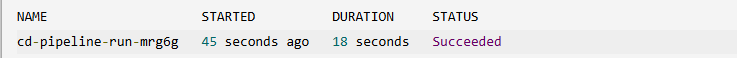

**You can check the logs of the last run with:**

```
tkn pipelinerun logs --last
```

# Conclusion

**Congratulations!** 

You have just added a task from the Tekton Catalog instead of writing it yourself. You should get into the habit of always checking the Tekton Catalog at Tekton Hub before writing any task. **Remember: “`A line of code you did not write is a line of code that you do not have to maintain!`”**

In this lab, you learned how to use the `git-clone` task from the Tekton catalog. You learned how to install the task locally using the Tekton CLI and how to modify your pipeline to reference the task and configure its parameters. You also learned how to start a pipeline with the Tekton CLI `pipeline start` command and monitor its output using `--showlog`.